In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

%load_ext autoreload
%autoreload 2
import sys
sys.path.append("/Users/austin/code/liquidity-distribution-history/")
from swap_utils import *
from pool_state import v3Pool
from swap import swap
from sim import sim

from tqdm import tqdm

from collections import defaultdict

In [92]:
pool_add = '0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8'
pool = v3Pool(pool_add, initialize = False)

/opt/homebrew/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 

Initializing liquidity


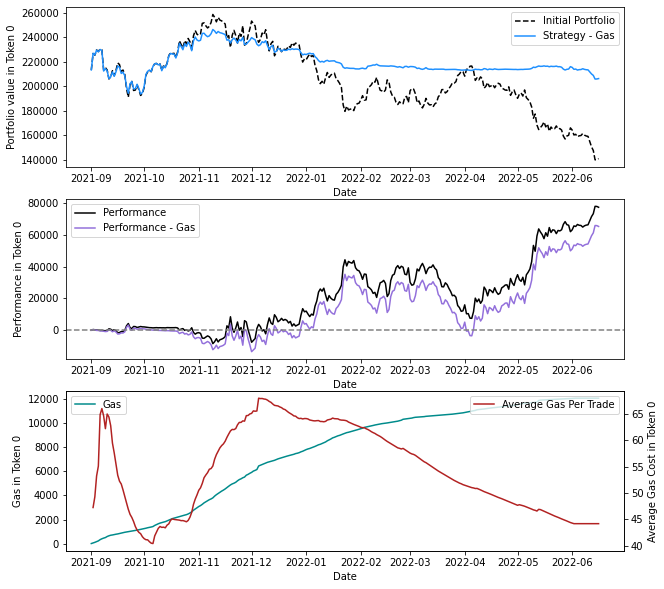

In [93]:
initial_port = [100000 * 1e6, 33 * 1e18]
start, end = pd.to_datetime("09-01-2021"), pd.to_datetime('06-01-2022')
## create trades
token0 = pool.getToken0()
token1 = pool.getToken1()

pct = .05
times = [*pd.date_range(start=start, end=end) + pd.Timedelta("6h")]
trades = [[t, np.random.choice([token0, token1])] for t in times]
trades = [t + [initial_port[0] * pct if t[1] == token0 else initial_port[1] * pct] for t in trades]
s = sim(pool)

# define trades for trades
s.defBTDate(start, end + pd.Timedelta("15d"))
s.loadPort(initial_port)

# load trades
s.loadTrades(trades)

# apply and compute performance
s.applyTrades(gas = True)
sim_df = s.createPerformance()

# plot performance
fig = s.plotMetrics()

fig.savefig("performance.png")

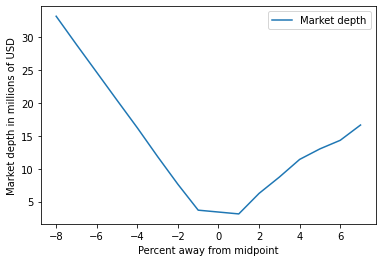

In [98]:
# swapToPrice
tokenIn = "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48"
tokenOut = "0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2"
as_of = 14814941
#pcts = [-.08, -.02, -.01, -.005, -.001, .001, .005, .01, .02, .04, .08]
pcts = [i / 1000 for i in range(-80, 80, 10)]
pcts.remove(0)

swapParams = {'tokenOut': tokenIn,
            'pcts': pcts,
            'as_of': as_of}

out, heur = pool.swapToPrice(swapParams)

## plotting
fig, ax = plt.subplots()

out_df = pd.DataFrame(out, columns = ['md', 'pct']).set_index("pct")
out_df.index = out_df.index * 100
out_df = out_df['md'] / 1e6 / 1e6
ax.plot(out_df, label = "Market depth")
ax.set_ylabel("Market depth in millions of USD")
ax.set_xlabel("Percent away from midpoint")
ax.legend()

Text(0.5, 0, 'Price (WETH/USDC)')

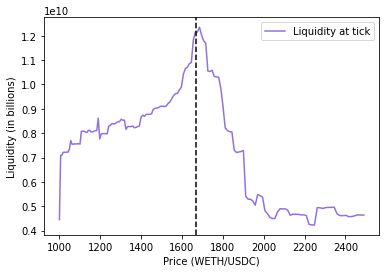

In [108]:
x, y = pool.createLiq(np.inf)
x, y = np.array(x), np.array(y)
px = pool.getPriceAt(np.inf)
liq_df = pd.DataFrame(x, columns=["ticks"])
liq_df["liquidity"] = y
liq_df['px'] = 1 / (1.0001 ** liq_df['ticks']) * 1e12

plot_df = liq_df[(liq_df['px'] < 2500) & (liq_df['px'] > 1000)].set_index("px")

fig, ax = plt.subplots()

ax.plot(plot_df['liquidity'], label = "Liquidity at tick", color = 'mediumpurple')
ax.axvline((1 / px ** 2) * 1e12, color = 'black', linestyle = "--")
ax.legend()
ax.set_ylabel("Liquidity (in billions)")
ax.set_xlabel("Price (WETH/USDC)")